Contributers:

Sam Korman, Ansh Shah, Saman Verma

Abstract:

We start our simulation by modeling an electric dipole with a spring potential. The dipole is separated by a given equilibrium distance. The dipole is then driven by an external sinusoidal electric field, which can be thought of as light with a certain frequency hitting a molecule, and causing oscillations in the electric dipole. The first part of our simulation is to plot the trajectory of these oscillations for various frequencies, and determine which resonant frequency of the driven electric field causes the largest oscillations in the electric dipole. We also show that driving the dipole with a force that is the superposition of two sinusoidal forces results in the same trajectory as that of the addition of the trajectories due to both of those forces separately. For the second part of the simulation, we will calculate the resonant frequency theoretically and use this value to simulate how changes in the electric field propagate away from the dipole at the speed of light. We will use the fact that the speed of light is the fastest speed of information to determine how the electric field should act a certain distance away from the dipole. This simulation will show us how the oscillating charged particles cause electromagnetic waves to propagate away from the dipole, at frequencies determined by the driving force. Ultimately, we will use this fact to show that molecules will scatter light at different frequencies better than others due to their intrinsic characteristics, which explains why different molecules have different emission spectrums of light.


Motivation:
   
We were interested in modeling how a dipole reacts to an external Electric Field. We wanted to measure the trajectory of the dipole and the field at each point along with observing a possible time delay (which we simulate by a smaller speed of light). We found all of that interesting and relevant because the way these dipoles work is very similar to how molecules in the atmosphere interact with the Sun’s rays. By having this model, we can create a better simulation of atmospheric interaction with the Sun.



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as ani
import matplotlib.cm as cm 

# allows animation features within notebook
%matplotlib notebook

# NOTE: sometimes this causes unknown errors in plotting when the code is first being run
#       so if some of the plots near the bottom don't show up just run them again.

In [2]:
# constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
k = 1 / (4 * np.pi * e0)

# Use an artificial speed of light in order to visualize how it changes electric field evolution
c = 0.5
dt = 0.0007

In [3]:
# create timesteps array with a given dt small enough to calculate
# both dipole trajectory and electric field evolution accurately
t0 = 0
t1 = 40
timesteps = np.arange(t0, t1, dt)

We first set up a dipole class that will be able to calculate the trajectory of the dipole over the timesteps array, and will hold all the data that we will need for the subsequent pieces of code. The particle class is used as a data storage system for the calculation of the dipole trajectory.

The dipole is modeled as a simple harmonic oscillator that has its initial position at its lowest energy state. We can treat both particles as a single system if we use the effective mass: $ m_{ef} = \frac {m_1 m_2} {m_1 + m_2} $. Since the mass of both particles are the same, we have $ m_{ef} = \frac {m^2} {2m} $. Since this is a harmonic oscillator, it has a natural frequency of $ \omega = \sqrt { \frac {k} {m} } $, where $k$ is the spring constant of the system, determined by the spring potential of the dipole.

When we initialize a dipole object, we must provide an external force array so that we can model the system as a driven harmonic oscillator. Without the external force, the dipole would stay at the same position the entire time. To calculate the trajectory of both particles, we apply the force from the applied electric field at each timestep, and then use numerical integration in order to calculate the velocity and position of the particles. These values are stored in arrays which can be used later. Since the system as a whole is a driven harmonic oscillator, we can see that it will have a resonant frequency equal to the natural frequency of the system, and if we apply the effective mass formula, we can see that this resonant frequency will be $ \omega_0 = \sqrt {\frac { 2 k} {m}} $.

In [13]:
#Sam wrote and Saman debugged
# class to store particle data in order to create dipole trajectory
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

# class that holds all information about a particular dipole, including trajectory given a certain external force
class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1, mass=1, k=1, external_force_arr=np.zeros(timesteps.size)):
        self.distance = distance
        self.charge = charge
        self.mass = mass
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/2, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=-self.charge, pos=np.array([distance/2, 0,0]))
        self.initial_position_1 = np.array([-distance/2, 0,0])
        self.initial_position_2 = np.array([distance/2, 0,0])
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros((self.timesteps.size, 3))
        self.pos2 = np.zeros((self.timesteps.size, 3))
        self.dist_center1 = np.zeros((self.timesteps.size, 3))
        self.dist_center2 = np.zeros((self.timesteps.size, 3))
        
        self.external_force_arr = external_force_arr
        
        self.vel_1 = np.zeros((self.timesteps.size, 3))
        self.accel_1 = np.zeros((self.timesteps.size, 3))
        
        self.vel_2 = np.zeros((self.timesteps.size, 3))
        self.accel_2 = np.zeros((self.timesteps.size, 3))
        
        self.k = k      
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        # Driven Oscillation models the movement of the dipole
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos
            self.pos2[i] = self.particle2.pos
            
            self.vel_1[i] = self.particle1.vel
            self.vel_2[i] = self.particle2.vel

            self.accel_1[i] = self.particle1.acc
            self.accel_2[i] = self.particle2.acc
            
            external_force = np.array([self.external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        self.dist_center1 = self.pos1 - self.initial_position_1
        self.dist_center2 = self.pos2 - self.initial_position_2
        
        return self.pos1, self.pos2    

In [5]:
def sinusoidal_force(E0,omega,timesteps, phase=0):
    return (E0 * np.sin(omega * timesteps + phase))

We drive the dipole that we set up with a time varying external force. this system is modelled by the following differential equation.
$$ mx'' + kx = Fsin(\omega t)$$

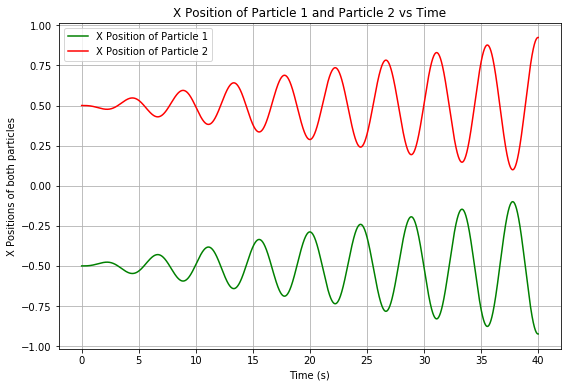

In [14]:
#Ansh wrote and debugged
k0 = 1 # spring constant
mass0 = 1 # mass of each particle
E0 = 0.03 # magnitude of electric field applied to dipole
omega = np.sqrt(2 * k0 / mass0) # theoretically calculated resonant frequency

# external driven sinusoidal force
sinusoidal_force_array = sinusoidal_force(E0,omega,timesteps)

# create dipole and calculate trajectory
dipole = Dipole(timesteps, mass=mass0, k=k0, external_force_arr=sinusoidal_force_array)
dipole.calc_trajectory()

fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole.pos1[:, 0], 'g', label = 'X Position of Particle 1')
ax1.plot(timesteps, dipole.pos2[:, 0], 'r', label = 'X Position of Particle 2')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Positions of both particles")
ax1.title.set_text("X Position of Particle 1 and Particle 2 vs Time")
ax1.legend()
plt.show()

Here we have the position of the dipole along the axis at which it moves according to time. We can see here that at this frequency, this dipole is at resonance as the amplitude of each particle’s position continually increase and the distance between each dipole is smaller at peaks and farther at troughs. For instance, in the first five seconds the particle is only very slightly removed from its initial starting position; however, by the time we reach 35 seconds, the particle ranges from almost -1 m to almost 0 m. 

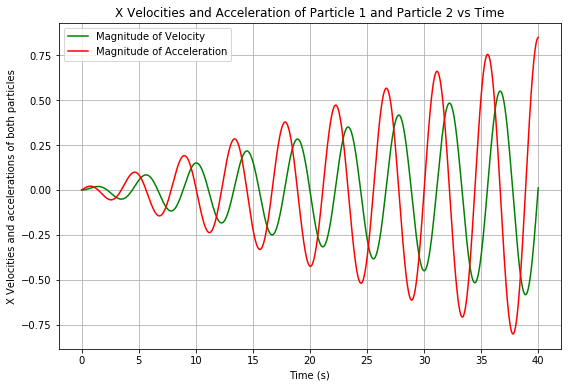

In [15]:
#Saman wrote and debugged 
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole.vel_1[:, 0], 'g', label = 'Magnitude of Velocity')
ax1.plot(timesteps, dipole.accel_1[:, 0], 'r', label = 'Magnitude of Acceleration')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Velocities and accelerations of both particles")
ax1.title.set_text("X Velocities and Acceleration of Particle 1 and Particle 2 vs Time")
ax1.legend()

plt.show()

Here we graph both particles’ velocities and acceleration on the x axis. This graph further proves we are at resonant frequency as the magnitude of the velocity and acceleration continually increase with time from .125 m/s within the first five seconds to over .75 m/s by the 40 second mark.


Here we evaluate the behaviour of dipole-spring systems under driving forces of different driving frequency and plot the response amplitudes. we notice that the response amplitude peaks at around 1.41 (i.e sqrt(2) ) which is the resonance frequency for this system.

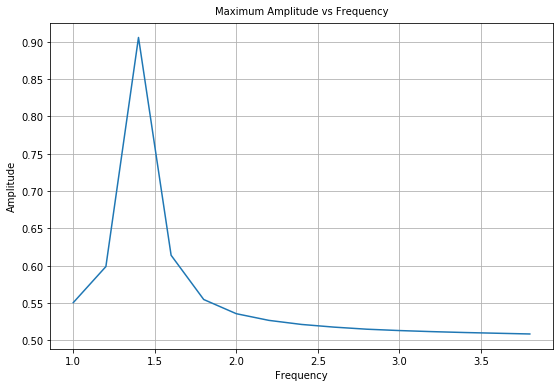

In [16]:
#Ansh wrote and debugged
# create range of frequencies for which to calculate trajectories
omega_arr = np.arange(1,4,0.2)

# create array to store amplitude of oscillation for each frequency
oscillation_amplitudes = np.zeros(np.shape(omega_arr))

for i, omega in enumerate(omega_arr):
    # create dipole with external force with given frequency
    external_force_arr = sinusoidal_force(E0,omega,timesteps)
    current_dipole = Dipole(timesteps, external_force_arr=external_force_arr)
    posA,posB = current_dipole.calc_trajectory()    
    
    # determine maximum amplitude for trajectory and store in array
    oscillation_amplitudes[i] = np.amax(posB)
    
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(omega_arr,oscillation_amplitudes)
ax1.grid()
ttl = ax1.text(.5, 1.05, '', transform = ax1.transAxes, va='top', ha = 'center')
ttl.set_text("Maximum Amplitude vs Frequency")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Amplitude")
plt.show()


In this graph, we found the resonant frequency of the dipole interaction. According to this graph, the frequency is 2^.5. We use this frequency for almost the entirety of the remaining project. 

Now we start investigating the behaviour of the electric field of the dipole as it oscillates. The following cells provide insight into the behavior of the electric field surrounding the dipole at the initial conditions of the dipole.

In [18]:
#Sam wrote and Ansh debugged
def calc_electric_field(dipole, point):
    ''' function to calculate electric field for a point from initial position of the dipole'''
    
    #OpenCourseWare
    
    dif1 = point - dipole.initial_position_1
    dif2 = point - dipole.initial_position_2
    
    r_mag1 = np.linalg.norm(dif1)
    r_mag2 = np.linalg.norm(dif2)
    
    Ex = dipole.charge * (dif1[0]*r_mag1**-3 - dif2[0]*r_mag2**-3)
    Ey = dipole.charge * (dif1[1]*r_mag1**-3 - dif2[1]*r_mag2**-3)
    Ez = dipole.charge * (dif1[2]*r_mag1**-3 - dif2[2]*r_mag2**-3)
    
    return np.array([Ex, Ey, Ez])

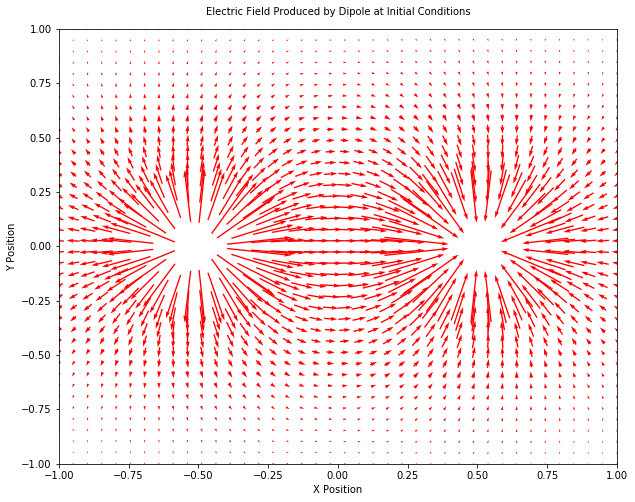

In [19]:
#Sam wrote and debugged
# This cell is to plot electric field around dipole at initial conditions
fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

# create meshgrid of points
Nsteps = 40
grid_min = -1
grid_max = 1

x, y = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))

# calculate E field at each point in meshgrid
E = calc_electric_field(dipole, [x, y, 0])

# find maximum magnitude for mask
magEfield = np.sqrt(E[0]**2 + E[1]**2 + E[2]**2)
maxMagEfield = np.max(magEfield)

# Don't plot points that are too large
mask_efield = np.where(magEfield < maxMagEfield * 0.02)

ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='top', ha = 'center')
ttl.set_text("Electric Field Produced by Dipole at Initial Conditions")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

Qplot = ax.quiver(x[mask_efield], y[mask_efield], 
                   E[0][mask_efield], E[1][mask_efield], 
                   units='inches',pivot='mid',color='r', scale=25)

Here we have a map of the Electric field because of the dipole at various positions at a single point in time. We can see that the Electric field is stronger near the dipoles than farther away and that the Electric field lines 'spread' from the positive charge and 'end' at the negative charge. Furthermore, the space right in between the dipoles have almost completely straight, linear, and horizontal lines (a characteristic of the dipole).

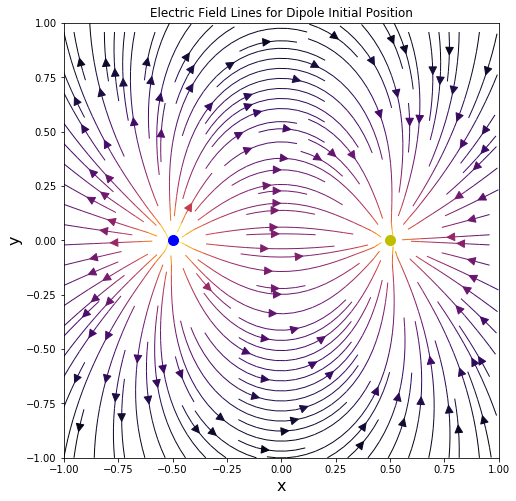

In [22]:
#Ansh wrote and Saman debugged
fig, ax1 = plt.subplots(1, figsize=(8,8))
color = 2 * np.log(magEfield)    # colors the arrows based on field strength

ax1.streamplot(x[0], x[1], E[0], E[1], color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

ax1.plot(dipole.initial_position_1[0],0,'o', markersize=10, color='b')   # indicate the location of particle 1
ax1.plot(dipole.initial_position_2[0],0,'o', markersize=10, color='y')   # indicate the location of particle 2


ax1.set_aspect('equal')
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xlabel('x', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
ax1.set_title("Electric Field Lines for Dipole Initial Position")
plt.show()

Here is another visualization of the dipole (blue represents positive charge and yellow represents negative charge).

We will now begin to analyze the behavior of the electric field as the dipole begins to oscillate. When the dipole changes it's position, the information that it's position has changed propogates at the speed of light. if the dipole starts moving at t = 0, then points surrounding the dipole will not have an updated electric field until the information traveling at the speed of light has reached that point. The information would take time $r/c$ to reach it where r is the seperation between the point and dipole. thus we can set up a new time for each point since as far as that point is concerned the dipole is stil in its former state. formally we write. 
$$t' = t + r/c$$ where $t'$ is the time that the current information at the dipole will reach a particular point in space.

We will use this information to build our simulation. We first set up arrays to hold the electric field due to both particles at each moment in time. We will loop through the position of the dipole, updating a single point in space as we go. In a single iteration, first we will calculate the electric field due to both particles at a point in space due to the current state of the dipole. Then, we will calculate the time at which this information will reach the given point in space, which will be a different time for the electric field produced by both particles, since they are at different locations. Then, we will find the index in our array at which this time occurs (using our binary search algorithm), and use this to store the values of the electric field in our previously created arrays. Now, we have two separate arrays filled with electric field data over time, but we are not certain that we have assigned a value for the electric field for each timestep in the array. In order to due this, we use the relaxation method, which will iteratively interpolate between values in each of the two arrays that we have, essentially making the electric field continuous over time. After this, we have filled both electric field arrays, so we can add them together to determine the combined contribution from both particles. We will now have a single array that stores the electric field over time for a particular point in space.

In [21]:
#Sam wrote and Saman debugged
# binary search algorithm used for electric field calculation. Time complexity O(log(n)).
def binary_search(array, value):
    '''binary search algorithm for value in an array'''
    low = 0
    high = array.size - 1
    midpoint = int((high - low) / 2)
    n = 0
    
    if value > array[high]:
        return -1
    
    while(low <= high and n < array.size):
        n+=1
        midpoint = int((low + high) / 2)
        if array[midpoint] == value:
            return midpoint
        elif array[midpoint] > value:
            high = midpoint - 1
        elif array[midpoint] < value:
            low = midpoint + 1
    return midpoint


In [23]:
#Sam wrote and debugged
def relax(arr, relax_mask):
    '''relaxation method used to fill in gaps in arrays'''
    keep_same = arr[relax_mask]
    first = arr[0]
    last = arr[-1]    
    
    arr = (np.roll(arr,-1, axis=0) + np.roll(arr,1,axis=0))/2
    
    arr[relax_mask] = keep_same
    arr[0] = first
    arr[-1] = last
    return arr

In [24]:
#Sam wrote and Ansh and Saman debugged
# class to store electric field evolution of a single point in space over time
class point_in_space():
    
    def __init__(self, x, y, z, timesteps, relax_iterations=1000):
        self.xyz = np.array([x, y, z]) # position of point in space
        self.electric_field = np.zeros((timesteps.size, 3)) # combined electric fields
        self.electric_field_1 = np.zeros((timesteps.size, 3)) # electric field contribution from particle 1
        self.electric_field_2 = np.zeros((timesteps.size, 3)) # electric field contribution from particle 2
        self.first_index = 0 # first index that electric field from both particles reaches point in space
        self.first_index1 = 0 # first index that electric field from particle 1 reaches point in space
        self.first_index2 = 0 # first index that electric field from particle 2 reaches point in space
        self.iteration_flag = False
        self.relax_iterations = relax_iterations # iterations for relaxation method
        self.timesteps = timesteps
        
        self.indices = np.zeros(timesteps.shape)
        
    def reset_electric_field(self):
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))
        self.electric_field = np.zeros((timesteps.size, 3))
        
    def populate_electric_field_array(self, pos1, pos2, time, i):
        '''function to populate electric field array at a certain point in time'''
        r1 = self.xyz - pos1 # distance from particle 1
        r2 = self.xyz - pos2 # distance from particle 2
        
        #Lewin 
        time1 = time + np.linalg.norm(r1) / c # time when particle 1 information will actually reach point in space
        time2 = time + np.linalg.norm(r2) / c # time when particle 2 information will actually reach point in space

        # indices of time to reach point in space
        index1 = binary_search(self.timesteps, time1) 
        index2 = binary_search(self.timesteps, time2)

        self.indices[i] = index1

        # calculation of the elctric field at this point in time
        r_mag1 = np.linalg.norm(r1)
        r_mag2 = np.linalg.norm(r2)

        Ex1 = dipole.charge * (r1[0]*r_mag1**-3)
        Ey1 = dipole.charge * (r1[1]*r_mag1**-3)
        Ez1 = dipole.charge * (r1[2]*r_mag1**-3)

        Ex2 = -dipole.charge * (r2[0]*r_mag2**-3)
        Ey2 = -dipole.charge * (r2[1]*r_mag2**-3)
        Ez2 = -dipole.charge * (r2[2]*r_mag2**-3)

        # end calculation if we have reached the end of our timesteps array
        if index1 != -1:
            self.electric_field_1[index1] = np.array([Ex1, Ey1, Ez1])
        if index2 != -1:
            self.electric_field_2[index2] = np.array([Ex2, Ey2, Ez2])

        if index1 == -1 and index2 == -1:
            self.iteration_flag = True

        # store first indices when dipole movement will reach point in space
        if(i == 0):
            self.first_index1 = index1
            self.first_index2 = index2
            self.electric_field_1[:index1] = np.array([Ex1, Ey1, Ez1])
            self.electric_field_2[:index2] = np.array([Ex2, Ey2, Ez2])
            
    def calculate_electric_field(self, dipole):
        '''function to completely calculate electric field evolution over time'''
        
        #OpenCourseWare
        self.iteration_flag = False
        self.reset_electric_field()
        pos1 = dipole.pos1
        pos2 = dipole.pos2
        for i, t in enumerate(self.timesteps):
            # populate arrays for certain point in time
            self.populate_electric_field_array(pos1[i], pos2[i], t, i)
            if self.iteration_flag:
                break # end computation if reached end of timesteps array
        
        self.first_index = np.max(self.first_index1 + self.first_index2)
        
        # fill in gaps in array because not all values in timesteps will be filled at this point
        self.relax_electric_fields()
        
        # add contributions of electric field from both particles
        self.electric_field = self.electric_field_1 + self.electric_field_2
        
    def relax_electric_fields(self):
        '''iterative relaxation method used in order to fill gaps in electric field array'''
        
        # want to leave already calculated points the same
        relax_mask_1 = np.where(np.abs(self.electric_field_1) != 0)
        relax_mask_2 = np.where(np.abs(self.electric_field_2) != 0)

        for i in range(self.relax_iterations): # fill in gaps between calculated points for both arrays
            self.electric_field_1 = relax(self.electric_field_1, relax_mask_1)
            self.electric_field_2 = relax(self.electric_field_2, relax_mask_2)

In [33]:
# example point in space
p1 = point_in_space(-0.750, 0.5, 0, timesteps)
p1.calculate_electric_field(dipole)

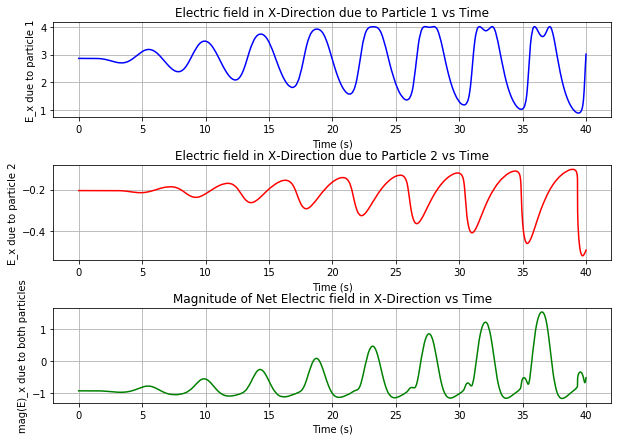

In [34]:
#Ansh wrote and Saman debugged
# This cell is for plotting different components of the calculated electric field for p1

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps[:], p1.electric_field_1[:, 1], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")

ax2.plot(timesteps[:], p1.electric_field_2[:, 1], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("E_x due to particle 2")


ax3.plot(timesteps, p1.electric_field[:, 0], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_x due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()

ax1.title.set_text("Electric field in X-Direction due to Particle 1 vs Time")
ax2.title.set_text("Electric field in X-Direction due to Particle 2 vs Time")
ax3.title.set_text("Magnitude of Net Electric field in X-Direction vs Time")

fig.subplots_adjust(hspace=.5)

In these three graphs we see the Electric field in the X-Direction due to both particles and the net Electric Field in the x direction at a random point in space ((-.75, .5, 0)). Here we see that particle 1 has a much higher effect on the electric field than particle 2. Furthermore, in the first graph, we see these divots on the peaks of the graphs. We believe this is a numerical error that arises due to the dipole getting really close to the particle. We see this divot again at magnitude of Net Electric Field at those same times. However, we see that the Net Electric Field varies drastically as time increases.

In [35]:
#Sam wrote and debugged
def calculate_vector_evolution_array(x, y, dipole):
    ''' function that calculates vector evolution for a meshgrid of points '''
    vector_evolution = np.empty(x.size, dtype=point_in_space) # create array of points
    num_points = x.size
    for i in range(num_points):
        point = point_in_space(x[i], y[i], 0, timesteps)
        point.calculate_electric_field(dipole)
        vector_evolution[i] = point # populate array
        
        # log calculation number becuase these calculations can take a very long time
        print("calculated electric field evolution ", (i + 1), "out of ", num_points)
    
    return vector_evolution

In [36]:
#Sam wrote and Ansh and Saman debugged
def get_2D_electric_field(p_array, unit_vectors=True):
    '''function to calculate vectors for plotting from array of points'''
    x = np.zeros(p_array.size)
    y = np.zeros(p_array.size)
    Ex = np.zeros((p_array.size, timesteps.size))
    Ey = np.zeros((p_array.size, timesteps.size))
    for i, point in enumerate(p_array):
        x[i] = point.xyz[0]
        y[i] = point.xyz[1]
        Ex_current = point.electric_field[:, 0]
        Ey_current = point.electric_field[:, 1]
        
        if unit_vectors: # calculate unit vectors
            mag_vec = np.sqrt(Ex_current**2 + Ey_current**2) # magnitude of individual vectors
            Ex[i] = Ex_current / mag_vec # divide by magnitude
            Ey[i] = Ey_current / mag_vec   
        else:
            Ex[i] = Ex_current
            Ey[i] = Ey_current
        
    return x, y, Ex, Ey


For our animation of the electric field surrounding the dipole, we calculated the electric field evolution for a meshgrid of points surrounding the dipole, and animated the changes over time. We have provided videos of our animations because the calculation is very computationally exhaustive and takes a long time to run, although the code for the animation is below.

The first animation below shows the behavior of the electric field with a fast speed of light. The dipole is driven at the resonant frequency. We can see that the electric field updates quickly with respect to the movement of the dipole, and that the surrounding electric field oscillates more as the oscillations in the dipole increase

<h1> Electric Field Evolution with Fast Speed of Light </h1>

<video width="50%" height="50%" controls src="Fast Speed of Light Oscillations.mov" />

The second animation shows the electric field evolution with a slower speed of light. In this animation it is very clear how the fact that the information travels at the speed of light causes propagation of the wave away from the dipole. The electric field oscillates over time, but out of phase with the original movements of the dipole since it takes time for the information to reach each point in space.

<h1> Electric Field Evolution with Slow Speed of Light </h1>

<video width="50%" height="50%" controls src="Slow Speed of Light Oscillations.mov" />

This third animation shows that the amplitude of oscillations greatly depends on whether or not the dipole is being driven at the resonant frequency. Compared to the previous animations, we barely see movement in the electric field, which confirms that driving the dipole at the resonant frequency results in a larger amplitude in the oscillations of the corresponding electric field.

<h1> Electric Field Evolution at a Non-Resonant Frequency </h1>

<video width="50%" height="50%" controls src="Non-Resonant Frequency Oscillations.mov" />

Below is the code for creating these animations. Changing the Nsteps variable will change the amount of points modeled around the dipole and changing the grid_min and grid_max variables will change the range of the points sampled around the dipole. Right now we have it set to a small sample size of points.

In [37]:
#Sam wrote and debugged
# WARNING: this cell takes a long time to process, and is not entirely necessary if you watch the embedded videos

# create a meshgrid of points around dipole in which to calculate electric field evolution
Nsteps = 4
grid_min = -1
grid_max = 1

x_grid, y_grid = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))

x_test = np.ravel(x_grid)
y_test = np.ravel(y_grid)

# store array of calculated points
p_array_meshgrid = calculate_vector_evolution_array(x_test, y_test, dipole)

calculated electric field evolution  1 out of  16
calculated electric field evolution  2 out of  16
calculated electric field evolution  3 out of  16
calculated electric field evolution  4 out of  16
calculated electric field evolution  5 out of  16
calculated electric field evolution  6 out of  16
calculated electric field evolution  7 out of  16
calculated electric field evolution  8 out of  16
calculated electric field evolution  9 out of  16
calculated electric field evolution  10 out of  16
calculated electric field evolution  11 out of  16
calculated electric field evolution  12 out of  16
calculated electric field evolution  13 out of  16
calculated electric field evolution  14 out of  16
calculated electric field evolution  15 out of  16
calculated electric field evolution  16 out of  16


<IPython.core.display.Javascript object>


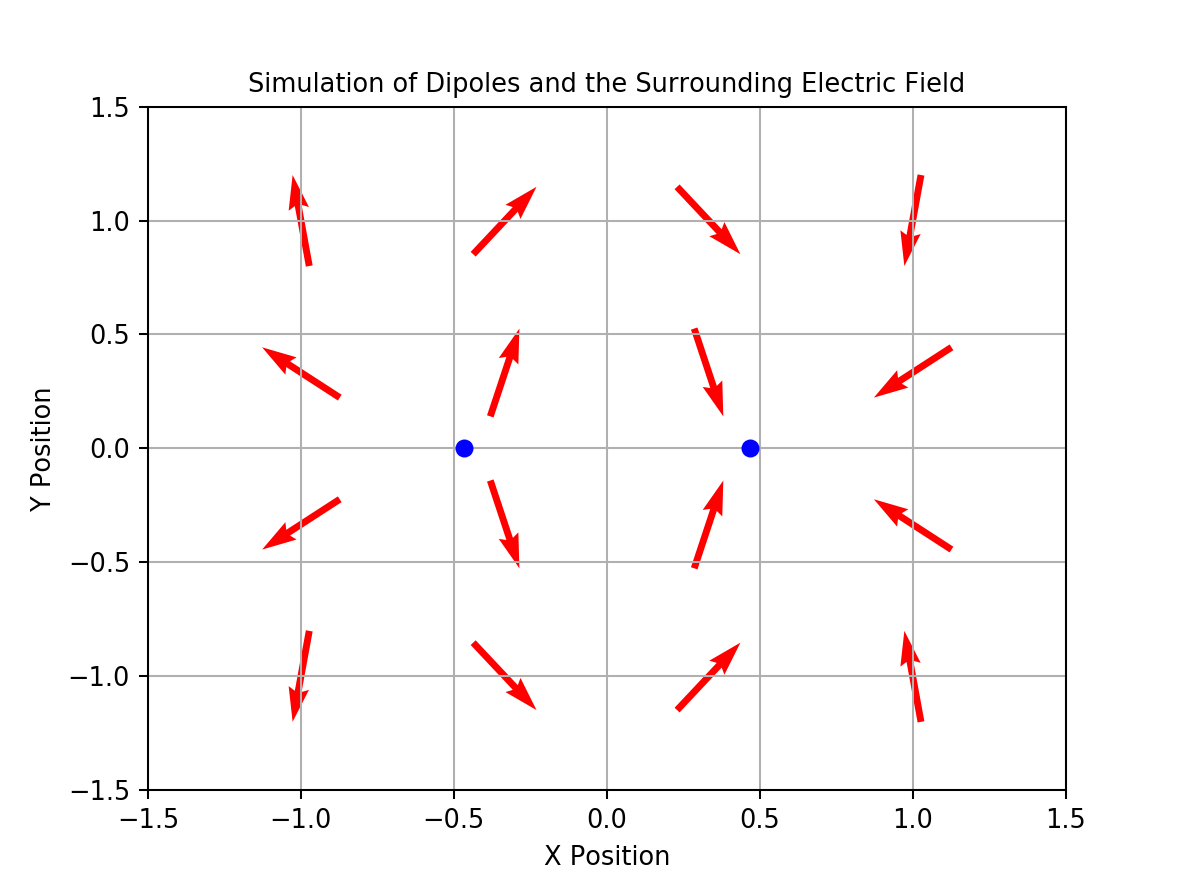

In [38]:
#Ansh wrote and Sam debugged
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
initial_index = 0 # index to start the simulation at
speed_factor = 10 # speed of simulation
scale_factor = 1 # scale to change size of vectors
frame_num = int(timesteps.size / speed_factor) # number of frames before simulation repeats

p_array = p_array_meshgrid # use meshgrid from before, although can be any array of points
x, y, Ex, Ey = get_2D_electric_field(p_array, unit_vectors=True) # calculate vectors for plotting
    
plt.grid()

# plot initial conditions
E_changing_plot = ax.quiver(x, y, 
                   Ex[:, 0], Ey[:, 0], 
                   units='inches',pivot='mid',color='r', scale=2)

pos1 = dipole.pos1
pos2 = dipole.pos2

# plot initial positions for dipole trajectory
dipole_plot, = ax.plot([pos1[0][0], pos2[0][0]], [pos1[0][1], pos2[0][1]], 'bo')

ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='top', ha = 'center')
    
def plot_point_in_space(i):
    
    # calculate x and y vector components for each point in space
    x_component = Ex[:, i * speed_factor] * scale_factor
    y_component = Ey[:, i * speed_factor] * scale_factor
    
    # update electric field plot
    E_changing_plot.set_UVC(x_component, y_component)
    
    dipole_x = [pos1[i * speed_factor, 0], pos2[i * speed_factor, 0]]
    
    dipole_plot.set_xdata(dipole_x) # dipole only oscillates in x-direction
    
    ttl.set_text("Simulation of Dipoles and the Surrounding Electric Field")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    
    return dipole_plot, E_changing_plot

# animation object
anim = ani.FuncAnimation(fig, plot_point_in_space,
                               frames=frame_num, interval=1, blit=False)
plt.show()

Here we have an animation of the dipoles oscillating and the resulting Electric Field at various points.

The next couple cells analyze what happens when we drive the dipole with a piecewise constant force rather than a sinusoidally varying force. The purpose of this is to show that a single spike in acceleration of the dipole will cause a single spike in the electric field, and it would otherwise be constant.

In [26]:
#Ansh wrote and Saman debugged
# This cell is for creating a piecewise force applied to the dipole without
# any internal spring potential in the dipole
E0_piecewise = 0.02 # magnitude of force

def piecewise_force(timesteps,E0):
    force = np.zeros(np.shape(timesteps))
    for i in range(np.size(timesteps)):
        if i < np.size(timesteps)/4: # if we're in first quadrant of time, apply force
            force[i] = E0
        else:                        # otherwise, apply 0 force
            force[i] = 0
    return force
 

# create dipole for piecewise force
piecewise_force = piecewise_force(timesteps,E0_piecewise)
dipole_piecewise = Dipole(timesteps = timesteps, distance =1,k = 0, external_force_arr=piecewise_force)
posa,posb = dipole_piecewise.calc_trajectory()

# calculate electric field evolution at a point in space
new_point = point_in_space(0.5, 5, 0, timesteps)
new_point.calculate_electric_field(dipole_piecewise)

C:\Users\Vanita\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


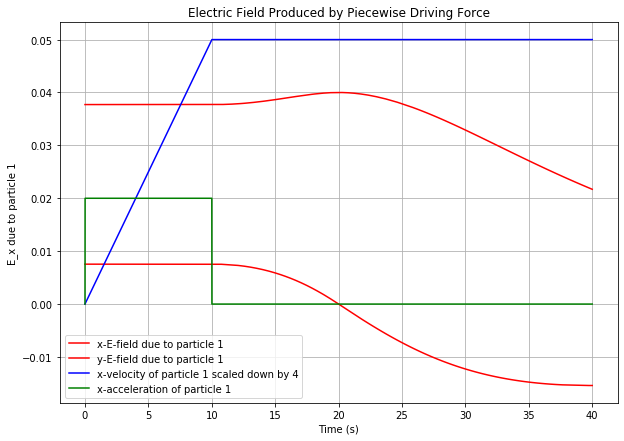

In [27]:
#Saman wrote and Ansh debugged
# This cell is for plotting data about the piecewise force

def magnitude(a1,a2):
    return np.sqrt(a1**2 + a2**2)


fig, (ax1) = plt.subplots(1, figsize=(10,7))
ax1.plot(timesteps, new_point.electric_field_1[:, 0], 'r-', label = 'x-E-field due to particle 1')
ax1.plot(timesteps, new_point.electric_field_1[:, 1], 'r-', label = 'y-E-field due to particle 1')
ax1.plot(timesteps, dipole_piecewise.vel_1[:, 0]/4, 'b-', label = 'x-velocity of particle 1 scaled down by 4')
ax1.plot(timesteps, dipole_piecewise.accel_1[:, 0], 'g-', label = 'x-acceleration of particle 1')
ax1.grid()
ax1.legend()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
ax1.legend()
ax1.set_title("Electric Field Produced by Piecewise Driving Force")
plt.show()


For the next couple cells, we will explore the superposition principle in terms of driving frequencies. First, we will examine what happens to a dipole that is driven by two different sinusoidal external forces added together, with varying amplitudes, frequencies, and phases. Second, we will apply these same exact sinusoidal forces to two separate dipoles, and we can show how we can describe the oscillations of the dipole with both frequencies by analyzing what happens when we apply the forces individually. Theoretically, we should have that $ \text {dipole}_{\text superposition}.pos = \text {dipole}_{\text {one}}.pos + \text {dipole}_{ \text {two}}.pos $, due to the linearity of the driving forces.

In [28]:
#Ansh wrote and debugged
#Physics
# superposition
omega_1 = np.sqrt(3)
omega_2 = 2
E0_a = 0.02
E0_b = 0.03
phase_shift = 2*np.pi/3

# create a force that is the superposition of two different sinusoidal forces
superPos_force = sinusoidal_force(E0_a, omega_1, timesteps) + sinusoidal_force(E0_b, omega_2, timesteps, phase=phase_shift)

# apply superposition force to dipole
dipole_superPos = Dipole(timesteps = timesteps, distance =1,k = 1, external_force_arr=superPos_force)
dipole_superPos.calc_trajectory()

# calculate electric field evolution for superposition of electric fields
superPos_point = point_in_space(0.5, 3, 0, timesteps)
superPos_point.calculate_electric_field(dipole_superPos)

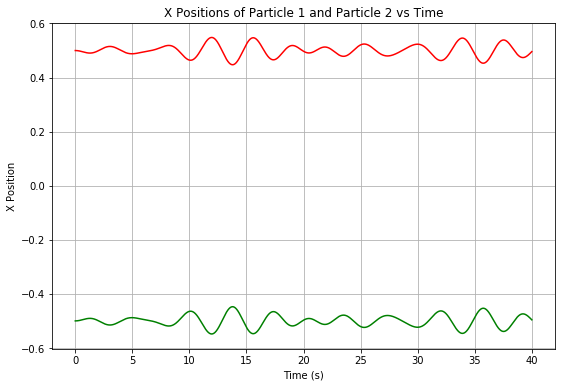

In [29]:
#Saman wrote and debugged
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole_superPos.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax1.plot(timesteps, dipole_superPos.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")


ax1.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
plt.show()

Here we have the position of the dipole along the axis at which it moves according to time. The unique thing about this graph is that the force is a superposition of two different sinusoidal forces instead of one external sinusoidal force. We can see here that at this frequency, this dipole is not at resonance as the amplitude of each particle’s position does not increase. Compared to the graph at resonant frequency, the dipole distance never comes closer than .8.

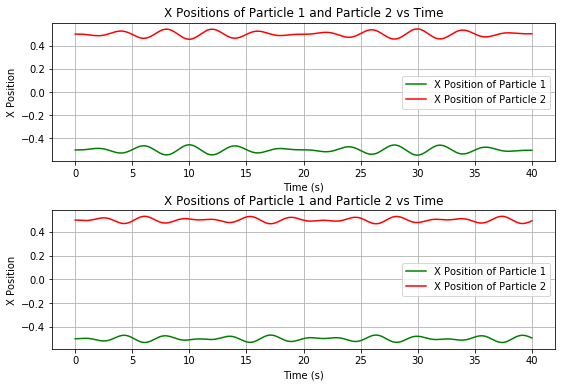

In [30]:
#Ansh wrote and Sam debugged
# calculate forces for the two sinusoidal forces earlier but separate this time
# additionally, create two different dipoles 
#Physics

superPos_1 = sinusoidal_force(E0_a, omega_1, timesteps)
dipole_one = Dipole(timesteps = timesteps, distance =1,k = 1, external_force_arr=superPos_1)
dipole_one.calc_trajectory()

superPos_2 = sinusoidal_force(E0_b, omega_2, timesteps, phase=phase_shift)
dipole_two = Dipole(timesteps = timesteps, distance =1,k = 1, external_force_arr=superPos_2)
dipole_two.calc_trajectory()

fig, (ax1,ax2) = plt.subplots(2, figsize=(9,6))

ax1.plot(timesteps, dipole_one.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax1.plot(timesteps, dipole_one.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax1.grid()
ax1.legend()
ax1.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")

ax2.plot(timesteps, dipole_two.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax2.plot(timesteps, dipole_two.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax2.grid()
ax2.legend()
ax2.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("X Position")

fig.subplots_adjust(hspace=.35)
plt.show()

Here we have the position of the dipole along the axis at which it moves according to time. We have two different dipoles except this time we calculated the forces separately instead of together. We can see here that at this frequency, this dipole is not at resonance as the amplitude of each particle’s position does not increase. Compared to the graph at resonant frequency, the dipole distance never comes closer than .8.

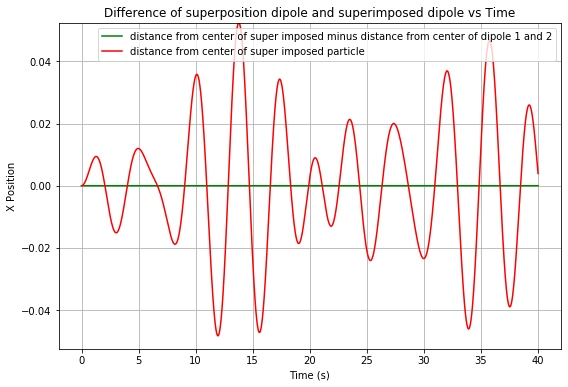

In [31]:
#Saman wrote and Sam debugged
fig, (ax1) = plt.subplots(1, figsize=(9,6))
ax1.set_xlim(-2, 42)

dipole_1_max = np.amax(np.abs(dipole_one.dist_center1[:, 0]))
dipole_2_max = np.amax(np.abs(dipole_two.dist_center1[:, 0]))
dipole_super_max = np.amax(np.abs(dipole_superPos.dist_center1[:, 0]))

plot_max = np.amax(np.array([dipole_1_max, dipole_2_max, dipole_super_max]))

ax1.set_ylim(-plot_max, plot_max)

# Subtract the oscillations from the superposition dipole from the two individual force dipoles added together.
difference = (dipole_one.dist_center1 + dipole_two.dist_center1) - dipole_superPos.dist_center1

ax1.plot(timesteps, difference[:,0], 'g-', label="distance from center of super imposed minus distance from center of dipole 1 and 2")
ax1.plot(timesteps, dipole_superPos.dist_center1[:, 0], 'r-', label="distance from center of super imposed particle")
ax1.grid()

ax1.title.set_text("Difference of superposition dipole and superimposed dipole vs Time")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")
ax1.legend()

plt.show()
#comfirms superposition

This plot is a sanity check to show the linearity of the system. Since the difference of the superposition dipole and the two individual particle positions is zero at all points in time, this shows that we can pull out different sinusoidal waves with different frequencies and amplitudes, and add each other their contributions together in order to see the full effect on the electric field. What this means is that it is viable to analyze what happens to the electric field at the resonant frequency, and determine that the oscillations caused by this frequency will be present even if there are other external forces present. The plot confirms the following differential equation:

$$ \mbox{ if } x(t) \mbox{ and } x_0(t) \mbox{ are solutions of the non-homogeneous differential equations } mx'' + kx = F_0sin(At) \mbox{ and } mx'' + kx = F_1sin(Bt) \mbox{ respectively,then } X = x(t) + x_0(t)  \mbox{ is a solution to } mx'' + kx = F_0sin(At) + F_1sin(Bt)$$


The linearity of the external forces along with our analysis of the dipole at the resonant frequency lead us to the main conclusion of our project. Since we have shown earlier that driving the dipole at its resonant frequency causes much larger oscillations, we can be pretty certain that when a whole range of light is applied to the dipole, the resonant frequency oscillations will dominate. When the contributions of all the different frequencies are added together, it will still be similar to the behavior shown at the resonant frequency. Exposing a molecule to white light is equivalent to driving it with a force that consists of many sinusoidal terms with different frequencies. Since the resonant frequency contribution will dominate the system, this can be described as the dipole ‘absorbing’ a range of frequencies and ‘scattering’ a select few frequencies that cause the largest oscillations. Because the resonant frequency of the dipole depends on its spring potential, this explains why different molecules have different emission spectrums. The light that is scattered by a molecule depends completely on its geometric structure and its chemical bonds. This is the main conclusion of our project, and is what we were hoping to achieve.

As a continuation of this project, it would be very helpful to analyze what happens to the electric field as we move much farther away from the dipole. We can see here that there is a ripple effect in the electric field caused by the oscillation of the dipole, but it is not quite clear that this effect will carry on into regions far beyond the dipole. Additionally, it is not clear that the oscillations in the electric field will be transverse to the propagation of the wave, which is something we would like to analyze in the future. In addition to this, it would also be helpful to view what happens to the magnetic field both close to the dipole and as we move further away. These are all ideas that could build upon what we have shown in this project.


Citations:

Lewin, Walter, director. 8.03 - Lect 14 - Accelerated Charges, Poynting Vector, Power, Rayleigh Scattering. 8.03 - Lect 14 - Accelerated Charges, Poynting Vector, Power, Rayleigh Scattering, 11 Feb. 2015, www.youtube.com/watch?v=QpGBs307qYs.

OpenCourseWare, MIT, director. Accelerated Charges Radiating Electromagnetic Waves. Accelerated Charges Radiating Electromagnetic Waves, 24 Oct. 2013, www.youtube.com/watch?v=wF8vLZ9ceb0&amp;t=1195s.

Physics, Real, director. 9.1.2 Electric Dipole Radiation. 9.1.2 Electric Dipole Radiation, 28 June 2015, www.youtube.com/watch?v=MGCHznSfCnQ&amp;t=593s.